In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imread
from PIL import Image
import tensorflow.contrib.layers as layers

202599


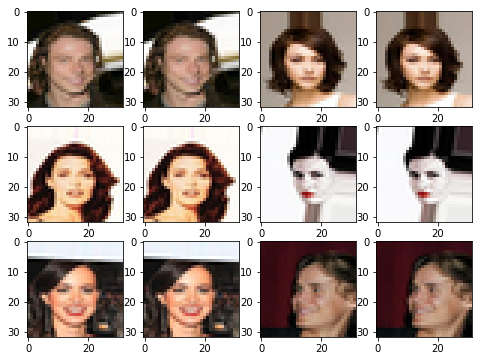

In [2]:
from os import listdir
from os.path import isfile, join
filepath = '../data/faces/img_align_celeba'
onlyfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
print(len(onlyfiles))

def read_random_data_batch(filepath, batch_size, img_resize_shape):
    global onlyfiles
    TOTAL_NUMBER_OF_IMAGES = len(onlyfiles)
    images = []
    idxs = np.random.choice(TOTAL_NUMBER_OF_IMAGES, batch_size)
    for idx in idxs:
        img = Image.open(filepath+'/'+str(onlyfiles[idx]))
        img = img.resize((img_resize_shape[0],img_resize_shape[1]), Image.ANTIALIAS)
        img = np.array(img)/255.0
        images.append(img)
    return np.array(images), np.zeros(batch_size)

def display_images(images):
    images = images.reshape(images.shape[0], images.shape[1], images.shape[2], images.shape[3])
    random_indices = np.random.choice(images.shape[0], 8)
    idx = 0
    plt.figure(figsize=(8, 6))
    for i in range(2):
        for j in range(4):
            plt.subplot(2, 4, 4*i+j+1)
            plt.imshow(images[random_indices[idx]])
            idx += 1
    plt.show()

def display_pair(original, generated):
    original = original.reshape(original.shape[0], original.shape[1], original.shape[2], original.shape[3])
    generated = generated.reshape(generated.shape[0], generated.shape[1], generated.shape[2], generated.shape[3])
    random_indices = np.random.choice(images.shape[0], 6)
    idx = 0
    plt.figure(figsize=(8, 6))
    for i in range(3):
        for j in range(2):
            plt.subplot(3, 4, 4*i+2*j+1)
            plt.imshow(original[random_indices[idx]])
            plt.subplot(3, 4, 4*i+2*j+2)
            plt.imshow(generated[random_indices[idx]])
            idx += 1
    plt.show()

images, labels = read_random_data_batch(filepath, 64, [32, 32])
display_pair(images, images)

In [3]:
def encoder(input_tensor, output_size):
    '''Create encoder network.
    Args:
        input_tensor: a batch of images [batch_size, 32, 32, 3]
    Returns:
        A tensor that expresses the encoder network
    '''
    net = layers.conv2d(input_tensor, 32, 5, stride=1)
    print("E1 - ", net.get_shape())
    net = layers.conv2d(net, 64, 5, stride=2)
    print("E2 - ", net.get_shape())
    net = layers.conv2d(net, 128, 5, stride=1, padding='VALID')
    print("E3 - ", net.get_shape())
    net = layers.dropout(net, keep_prob=0.9)
    
    net = layers.conv2d(net, 256, 3, stride=1, padding='VALID')
    print("E4 - ", net.get_shape())
    
    net = layers.conv2d(net, 128, 3, stride=1, padding='VALID')
    print("E5 - ", net.get_shape())
    
    net = layers.conv2d(net, 256, 3, stride=2, padding='VALID')
    print("E6 - ", net.get_shape())
    #net = layers.dropout(net, keep_prob=0.9)
    #net = layers.conv2d(net, 32, 3, stride=2, padding='VALID')
    #print("E5 - ", net.get_shape())
    net = layers.flatten(net)
    print("E7 - ", net.get_shape())
    return layers.fully_connected(net, output_size, activation_fn=None)

def decoder(input_tensor):
    '''Create decoder network.
        If input tensor is provided then decodes it, otherwise samples from
        a sampled vector.
    Args:
        input_tensor: a batch of vectors to decode
    Returns:
        A tensor that expresses the decoder network
    '''
    net = tf.expand_dims(input_tensor, 1)
    net = tf.expand_dims(net, 1)
    print("D1 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 128, 4, padding='VALID', stride=2)
    print("D2 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 64, 4, stride=1)
    print("D3 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 64, 4, stride=2)
    print("D4 - ", net.get_shape())
    #net = layers.conv2d_transpose(net, 32, 3, stride=2)
    #print("D5 - ", net.get_shape())
    net = layers.conv2d_transpose(net, 32, 3, stride=2)
    print("D5 - ", net.get_shape())
    net = layers.conv2d_transpose(
        net, 3, 5, stride=2, activation_fn=tf.nn.sigmoid)
    print("D6 - ", net.get_shape())
    net = tf.reshape(net, [-1, 32, 32, 3])
    return net

In [4]:
from __future__ import absolute_import, division, print_function

import math

import numpy as np
import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import losses
from tensorflow.contrib.framework import arg_scope

In [5]:
class VAE():

    def __init__(self, sess, hidden_size, batch_size, learning_rate):
        self.sess = sess
        self.input_tensor = tf.placeholder(
            tf.float32, [None, 32, 32, 3])

        with arg_scope([layers.conv2d, layers.conv2d_transpose],
                       activation_fn=tf.nn.elu,
                       normalizer_fn=layers.batch_norm,
                       normalizer_params={'scale': True}):
            with tf.variable_scope("model") as scope:
                encoded = encoder(self.input_tensor, hidden_size * 2)

                mean = encoded[:, :hidden_size]
                stddev = tf.sqrt(tf.exp(encoded[:, hidden_size:]))

                epsilon = tf.random_normal([tf.shape(mean)[0], hidden_size])
                input_sample = mean + epsilon * stddev

                self.output_tensor = decoder(input_sample)

            with tf.variable_scope("model", reuse=True) as scope:
                self.sampled_tensor = decoder(tf.random_normal(
                    [batch_size, hidden_size]))

        vae_loss = self.__get_vae_cost(mean, stddev)
        rec_loss = self.__get_reconstruction_cost(
            self.output_tensor, self.input_tensor)

        loss = vae_loss + rec_loss
        self.train = layers.optimize_loss(loss, tf.contrib.framework.get_or_create_global_step(
        ), learning_rate=learning_rate, optimizer='Adam', update_ops=[])
        print("Model constructed")
    
    def initialize_all_variables(self):
        self.sess.run(tf.global_variables_initializer())

    def __get_vae_cost(self, mean, stddev, epsilon=1e-8):
        '''VAE loss
            See the paper
        Args:
            mean:
            stddev:
            epsilon:
        '''
        return tf.reduce_sum(0.5 * (tf.square(mean) + tf.square(stddev) -
                                    2.0 * tf.log(stddev + epsilon) - 1.0))

    def __get_reconstruction_cost(self, output_tensor, target_tensor, epsilon=1e-8):
        '''Reconstruction loss
        Cross entropy reconstruction loss
        Args:
            output_tensor: tensor produces by decoder
            target_tensor: the target tensor that we want to reconstruct
            epsilon:
        '''
        return tf.reduce_sum(-target_tensor * tf.log(output_tensor + epsilon) -
                             (1.0 - target_tensor) * tf.log(1.0 - output_tensor + epsilon))

    def update_params(self, input_tensor):
        '''Update parameters of the network
        Args:
            input_tensor: a batch of flattened images [batch_size, 28*28]
        Returns:
            Current loss value
        '''
        return self.sess.run(self.train, {self.input_tensor: input_tensor})
    
    def run_CVAE(self, input_tensor):
        return self.sess.run(self.output_tensor, {self.input_tensor: input_tensor})
    
    def generate_and_show_images(self, num_samples):
        '''Generates the images using the model and saves them in the directory
        Args:
            num_samples: number of samples to generate
            directory: a directory to save the images
        '''
        imgs = self.sess.run(self.sampled_tensor)
        imgs = imgs.reshape([-1, 32, 32, 3])
        display_images(imgs)

E1 -  (?, 32, 32, 32)
E2 -  (?, 16, 16, 64)
E3 -  (?, 12, 12, 128)
E4 -  (?, 10, 10, 256)
E5 -  (?, 8, 8, 128)
E6 -  (?, 3, 3, 256)
E7 -  (?, 2304)
D1 -  (?, 1, 1, 512)
D2 -  (?, 4, 4, 128)
D3 -  (?, 4, 4, 64)
D4 -  (?, 8, 8, 64)
D5 -  (?, 16, 16, 32)
D6 -  (?, 32, 32, 3)
D1 -  (128, 1, 1, 512)
D2 -  (128, 4, 4, 128)
D3 -  (128, 4, 4, 64)
D4 -  (128, 8, 8, 64)
D5 -  (128, 16, 16, 32)
D6 -  (128, 32, 32, 3)
Model constructed
##### EPOCH -  0  ######
DISPLAYING GROUND / CVAE


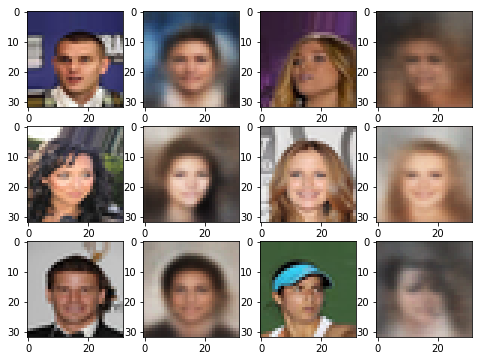

DISPLAYING GENERATED


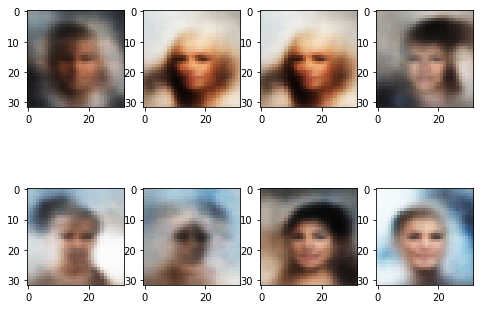

Loss 1699.439953


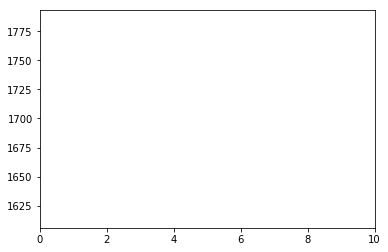

##### EPOCH -  1  ######
DISPLAYING GROUND / CVAE


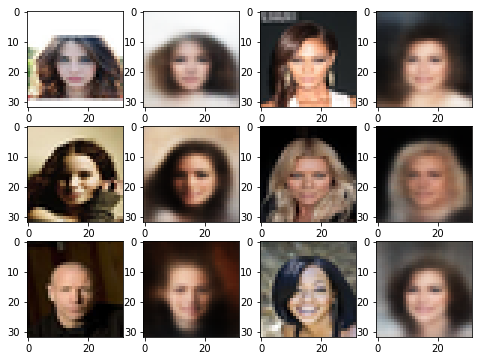

DISPLAYING GENERATED


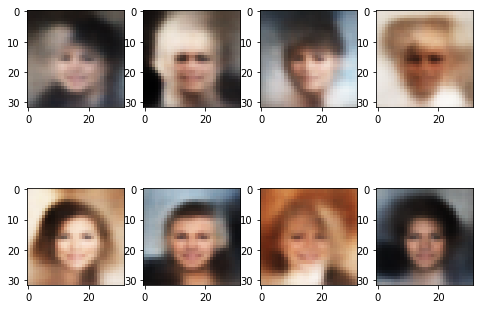

Loss 1641.532328


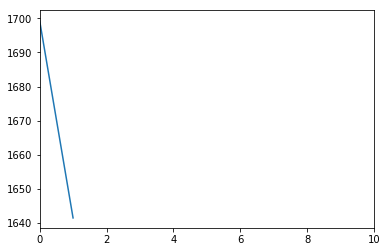

##### EPOCH -  2  ######
DISPLAYING GROUND / CVAE


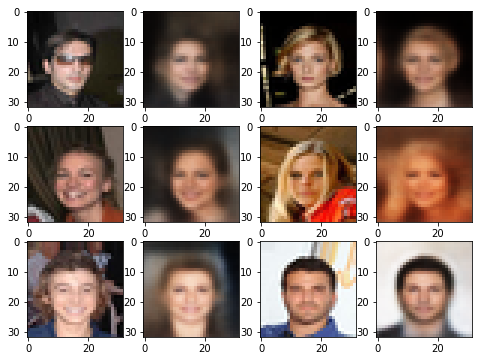

DISPLAYING GENERATED


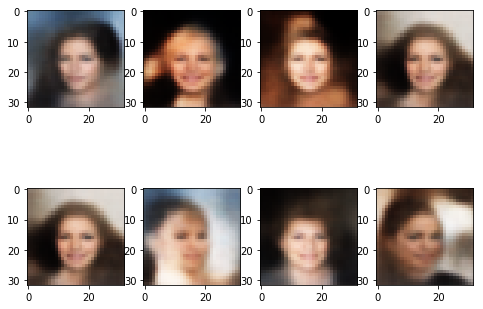

Loss 1635.105484


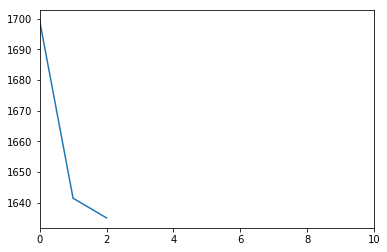

##### EPOCH -  3  ######
DISPLAYING GROUND / CVAE


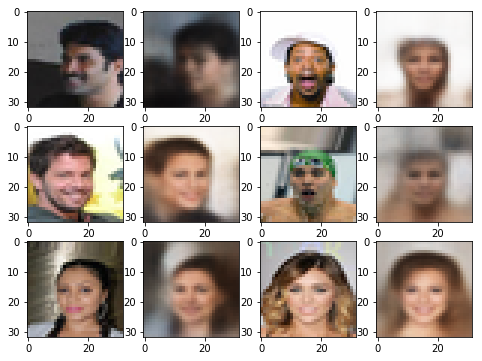

DISPLAYING GENERATED


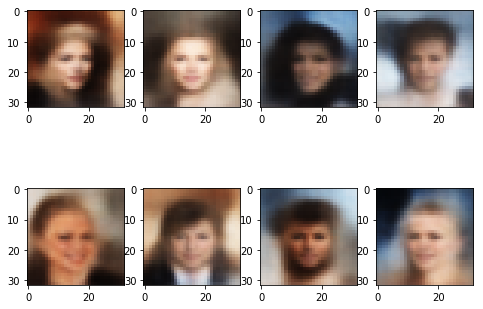

Loss 1631.766208


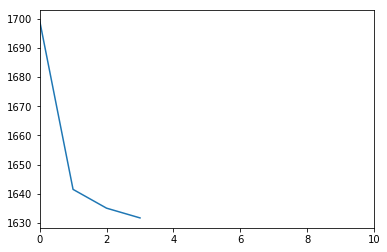

##### EPOCH -  4  ######
DISPLAYING GROUND / CVAE


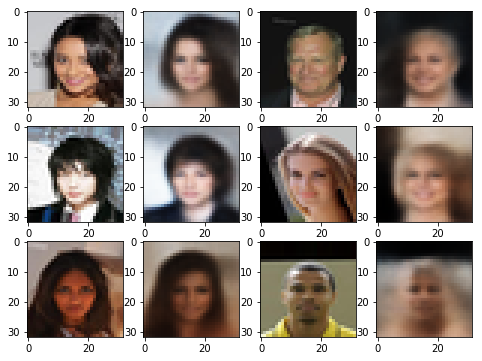

DISPLAYING GENERATED


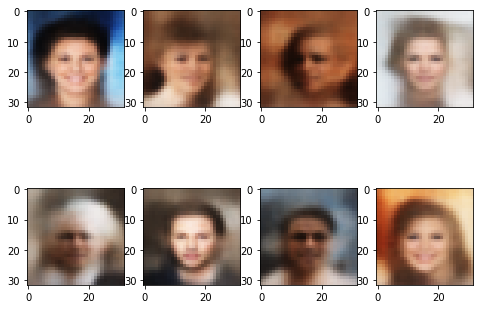

Loss 1628.588215


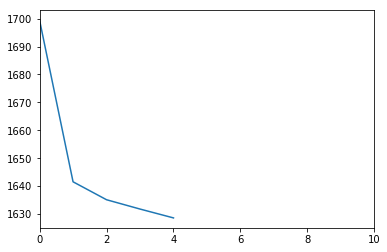

KeyboardInterrupt: 

In [6]:
batch_size = 128
hidden_size = 512
learning_rate = 5e-4
max_epoch = 10
updates_per_epoch = int(len(onlyfiles)/batch_size)

sess = tf.Session()

model = VAE(sess, hidden_size, batch_size, learning_rate)
model.initialize_all_variables()

with tf.device('/gpu:0'):
    
    training_loss_hist = []
    
    for epoch in range(max_epoch):
            training_loss = 0.0

            for i in range(updates_per_epoch):
                images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
                loss_value = model.update_params(images)
                training_loss += loss_value
            
            print("##### EPOCH - ", epoch, " ######")
            
            ground_images, _ = read_random_data_batch(filepath, batch_size, [32, 32])
            cvae_images = model.run_CVAE(ground_images)
            
            print("DISPLAYING GROUND / CVAE")
            display_pair(ground_images, cvae_images)
            
            print("DISPLAYING GENERATED")
            model.generate_and_show_images(batch_size)
            
            training_loss = training_loss / \
                (updates_per_epoch * batch_size)
            
            training_loss_hist.append(training_loss)
            
            print("Loss %f" % training_loss)
            
            plt.plot(training_loss_hist)
            plt.xlim([0, max_epoch])
            plt.show()


In [ ]:
saver = tf.train.Saver()
save_path = saver.save(sess, "./model/faces_cvae.ckpt")
print("Model saved successfully")